In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from collections import deque
from tqdm import tqdm  
import pandas as pd
import copy
from IPython.display import clear_output


In [2]:
eta_s=0.05
eta_d=0.1
eta_r=0.1
reward_eps=0.01

In [3]:
#rs=0,re=1,sd=2,gs=3,ge=4
P_0_matrix=np.array([[0.0,eta_s,1.0-eta_s,0.0,0.0],
                   [0.0,0,1,0.0,0.0],
                   [eta_d,0.0,1.0-2*eta_d,eta_d,0.0],
                   [0.0,0.0,1-eta_s,0.0,eta_s],
                   [0.0,0.0,1,0.0,0.0]])
P_0_matrix

array([[0.  , 0.05, 0.95, 0.  , 0.  ],
       [0.  , 0.  , 1.  , 0.  , 0.  ],
       [0.1 , 0.  , 0.8 , 0.1 , 0.  ],
       [0.  , 0.  , 0.95, 0.  , 0.05],
       [0.  , 0.  , 1.  , 0.  , 0.  ]])

In [4]:
P_1_matrix=np.array([[0.0,1,0.0,0.0,0.0],
                   [0.0,1-eta_r,eta_r,0.0,0.0],
                   [eta_d,0.0,1.0-2*eta_d,eta_d,0.0],
                   [0.0,0.0,0.0,0.0,1],
                   [0.0,0.0,1,0.0,0.0]])
P_1_matrix

array([[0. , 1. , 0. , 0. , 0. ],
       [0. , 0.9, 0.1, 0. , 0. ],
       [0.1, 0. , 0.8, 0.1, 0. ],
       [0. , 0. , 0. , 0. , 1. ],
       [0. , 0. , 1. , 0. , 0. ]])

In [5]:
#reward_epsilon=0.1
reward_matrix=[[0,0],[0.9,0.9],[0,0],[1.0,1.0],[0,0]]
action_space=[0,1]
state_space=[0,1,2,3,4]
N=20
M=10
epsilon=0.1
subsidy=0
arm_indexes=[i for i in range(N)]
gamma=0.99999

In [6]:
def step(state,state_space,action,P_0_matrix,P_1_matrix,reward_matrix):
  new_state=state
  if(action==1):
    new_state=np.random.choice(state_space,replace=True,p=P_1_matrix[state])
    reward=reward_matrix[state][1]
  else:
    new_state=np.random.choice(state_space,replace=True,p=P_0_matrix[state])
    reward=reward_matrix[state][0]
  return [new_state,reward]

In [7]:


def act(Q_values,epsilon,state):
  decision=np.random.binomial(n=1,p=epsilon,size=1)
  if decision==1:
    action=random.choice([0,1])
  else:
    action=np.argmax(Q_values[state])
  return action

In [8]:
Q=copy.deepcopy(reward_matrix)
nu=np.zeros((len(state_space),len(action_space)))
nu.shape

(5, 2)

In [9]:
alternative_indexes=[0 for _ in range(N)]
current_state=[0 for _ in range(N)]

In [10]:
rewards=[]
subsidies=[]
action_sums=[]
betas=[]
alphas=[]
epsilon=0.01


In [11]:
def alpha(i):
    # return 0.02
    return 1/(1+(i/5000))


In [12]:
for i in range(1,2000001):
  # top_M_indices=act(alternative_indexes,N,M,epsilon)
  action_sum=0
  reward_sum=0
  # alpha=1/(1+(i/500))

  # if i%50==0:
  #   beta=1/(1+np.ceil((i)*np.log(i)/10000))
  # else:
  #   beta=0
  if i%50==0:
    beta=1/(1+np.ceil((i)*np.log(i)/5000))
    kappa=1/(1+np.ceil((i**2)/20000))

  else:
    beta=0
    kappa=0
  # beta=0.005
  action_sum_flag=0
  
  for index in arm_indexes:
      # action=np.argmax(Q_values[index][current_state[index]])
      action=act(Q,epsilon,current_state[index])
      # if i%5000==0:
      #    action=0
      action_sum+=action

      
      x=step(current_state[index],state_space,action,P_0_matrix,P_1_matrix,reward_matrix)
      new_state=x[0]
      reward=x[1]
      
      if action==1:
        Q[current_state[index]][action]=(1-alpha(nu[current_state[index],action]))*(Q[current_state[index]][action])+alpha(nu[current_state[index],action])*(reward+max(Q[new_state])-(np.array(Q).sum())/10)
      else:
        Q[current_state[index]][action]=(1-alpha(nu[current_state[index],action]))*(Q[current_state[index]][action])+alpha(nu[current_state[index],action])*(reward+subsidy+max(Q[new_state])-(np.array(Q).sum())/10)
      nu[current_state[index],action]=nu[current_state[index],action]+1
      current_state[index]=new_state
      reward_sum+=reward
      
      #print(x)
  # print(i)
  #print(reward_sum)
  subsidy+=beta*(action_sum-M)/N
  # subsidy=subsidy_curr+beta*(action_sum-M)/N+kappa*(subsidy_curr-subsidy_last)
  # if i>0:
  #   subsidy_last=subsidy_curr
  # subsidy_curr=subsidy
  subsidies.append(subsidy)
#   if i%mod==0:
#      epsilon=1
#   else:
#      epsilon=0
#   epsilon=epsilon*gamma
#   if epsilon<=0.01:
#     epsilon=0.01
#   if i%10000==0:
#      mod=mod+1
  # if i==1000001:
  #    epsilon=0.001
  rewards.append(reward_sum)
  action_sums.append(action_sum)
  betas.append(beta)
  alphas.append(alpha)








Text(0.5, 1.0, 'Subsidy vs Steps for Health Worker Example')

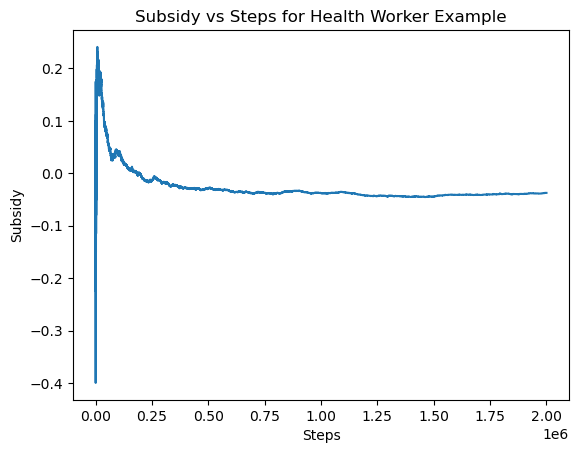

In [13]:
plt.plot(subsidies)
plt.xlabel('Steps')
plt.ylabel('Subsidy')
plt.title('Subsidy vs Steps for Health Worker Example')

In [14]:
df=pd.DataFrame(rewards)


Text(0.5, 1.0, ' Moving Average of reward for Health Worker Example ')

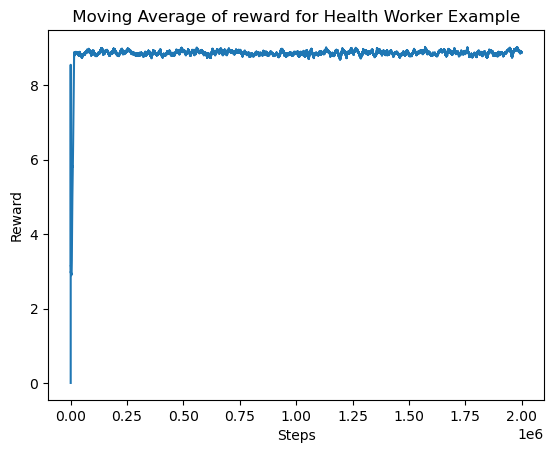

In [15]:
plt.plot(df[0].rolling(10000,min_periods=1).mean())
# plt.axhline(y = 14, color = 'r', linestyle = '-') 
plt.xlabel('Steps')
plt.ylabel('Reward')
plt.title(' Moving Average of reward for Health Worker Example ')


Text(0.5, 1.0, ' Moving Average of number of arms activated for Health Worker Example ')

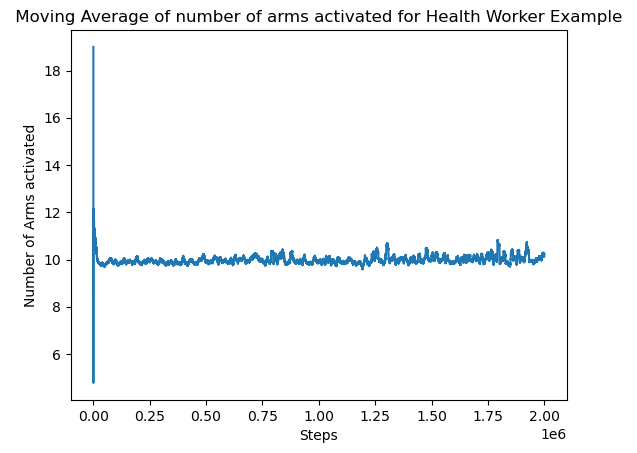

In [16]:
df['action_sums']=action_sums
plt.plot(df['action_sums'].rolling(10000,min_periods=1).mean())
plt.xlabel('Steps')
plt.ylabel('Number of Arms activated')
plt.title(' Moving Average of number of arms activated for Health Worker Example ')


In [17]:
for x in Q:
  print(x[1]-x[0])

4.684045250336902
4.218187578877759
-0.08907166294429764
-0.39127088594192344
0.15053932327584463


In [18]:
#using learnt indices
current_state=[0 for _ in range(N//2)]
current_state+=[3 for _ in range(N-N//2)]

reward_sums_alt_index=[]
reward_sums_whittle_index=[]
alternative_indexes=[0 for _ in range(N)]
for i in range(1,21):
  reward_sum_alt_index=0
  reward_sum_whittle_index=0
  for index in arm_indexes:
    alternative_indexes[index]=Q[current_state[index]][1]-Q[current_state[index]][0]
  indices_to_pull = sorted(range(len(alternative_indexes)), key = lambda j: alternative_indexes[j])[-M:]
  for index in arm_indexes:
    if index in indices_to_pull:
      x=step(current_state[index],state_space,1,P_0_matrix,P_1_matrix,reward_matrix)
      new_state=x[0]
      reward=x[1]
      current_state[index]=new_state
      reward_sum_alt_index+=reward
    else:
      x=step(current_state[index],state_space,0,P_0_matrix,P_1_matrix,reward_matrix)
      new_state=x[0]
      reward=x[1]
      current_state[index]=new_state
      reward_sum_alt_index+=reward
  reward_sums_alt_index.append(reward_sum_alt_index)


In [19]:
whittle_index_arms=[0 for _ in range(N)]
actual_whittle_indexes=[4,5,2,3,1]

current_state=[0 for _ in range(N//2)]
current_state+=[3 for _ in range(N-N//2)]
for i in range(1,21):
  reward_sum_whittle_index=0
  for index in arm_indexes:
    whittle_index_arms[index]=actual_whittle_indexes[current_state[index]]
  #print(whittle_index_arms)
  indices_to_pull = sorted(range(len(whittle_index_arms)), key = lambda j: whittle_index_arms[j])[-M:]
  # print(indices_to_pull)
  for index in arm_indexes:
    if index in indices_to_pull:
      x=step(current_state[index],state_space,1,P_0_matrix,P_1_matrix,reward_matrix)
      new_state=x[0]
      reward=x[1]
      current_state[index]=new_state
      reward_sum_whittle_index+=reward
    else:
      x=step(current_state[index],state_space,0,P_0_matrix,P_1_matrix,reward_matrix)
      new_state=x[0]
      reward=x[1]
      current_state[index]=new_state
      reward_sum_whittle_index+=reward
  reward_sums_whittle_index.append(reward_sum_whittle_index)

Text(0.5, 1.0, ' Moving Average of reward for Restart Example ')

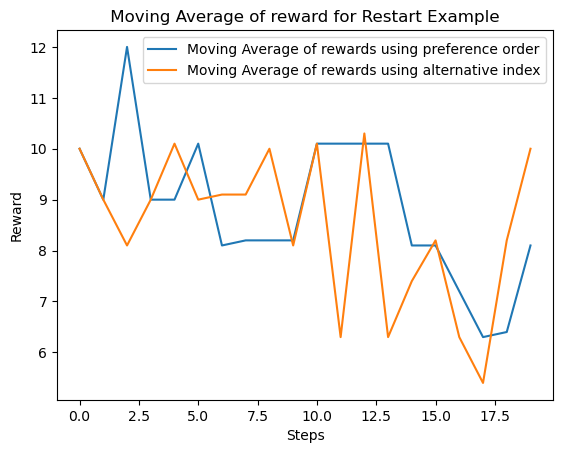

In [20]:
df=pd.DataFrame()
df['reward_whittle']=reward_sums_whittle_index
df['reward_alternate']=reward_sums_alt_index

plt.plot(df['reward_whittle'][:].rolling(1,min_periods=1).mean(),label='Moving Average of rewards using preference order')
plt.plot(df['reward_alternate'][:].rolling(1,min_periods=1).mean(),label='Moving Average of rewards using alternative index')
plt.xlabel('Steps')
plt.ylabel('Reward')
plt.legend()
plt.title(' Moving Average of reward for Restart Example ')

ValueError: x and y must have same first dimension, but have shapes (100000,) and (20,)

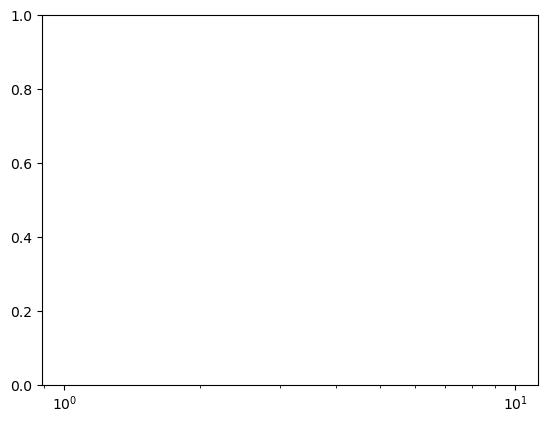

In [21]:
x = np.linspace(0, 100000, 100000)
y1=df['reward_whittle'][:].rolling(100000,min_periods=1).mean()
y2=df['reward_alternate'][:].rolling(100000,min_periods=1).mean()
plt.semilogx(x, y1,label='Moving Average of rewards using preference order')
plt.semilogx(x, y2,label='Moving Average of rewards using alternative index')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Semilogx Plot')
plt.legend()

# Show the plot
plt.show()



In [ ]:
x

array([1.])

In [ ]:
y1

0        10.00000
1         9.50000
2        10.00000
3         9.97500
4         9.98000
           ...   
99995     7.93485
99996     7.93438
99997     7.93403
99998     7.93367
99999     7.93360
Name: reward_whittle, Length: 100000, dtype: float64